# Index

1. Preprocesing raw data <br>
    1.1.  Reading files<br>
    1.2. Resizing<br>
    1.3. Splitting data (50%-50% now)<br>
    1.4. Binarization<br>
    1.5. Normalization<br>
2. Model implementation: Decision tree with Kernel PCA dimension reduction<br>
    2.1. K-fold validation<br>
    2.2. Grid search<br>

### Libraries

In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import KernelPCA

from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 

# 1. Preprocesing raw data

### 1.1 Reading data file

In [418]:
#df = pd.read_csv('mfeat-pix.txt', header=None, delimiter='\n')

with open('mfeat-pix.txt') as f:
    raw_dataset = f.readlines()

In [419]:
for i in range(len(raw_dataset)):
    array = raw_dataset[i].split(' ')
    a = np.array('')
    # We do an array with the items
    for item in array:
        a = np.append(a, item)

    # We delete empty items
    a = a[a != ""]

    # We change it from string to float
    a = a.astype('float64')

    if i == 0:
        dataset = a
    else:
        dataset = np.vstack([dataset, a])

### 1.2 Resizing

In [420]:
# Resizing to make 20 groups of 100 images, where each groups has 1 number
dataset = np.resize(dataset, (20, 24000))
dataset = np.array([np.resize(row, (100, 240))for row in dataset])

### 1.3 Splitting data (50%-50% now)

In [421]:
dataset.shape

(20, 100, 240)

In [422]:
# Each X array has 100 images of one number (10 numbers = 1000 images)
X_train = dataset[::2]
X_test = dataset[1::2]

In [423]:
# Creating array with the labels.
y_train=[0]
number = 0

for i in range(1,1000):
    if i%100 == 0 and i!=0:
        number+=1
        
    y_train = np.vstack([y_train, number])
    
y_test=y_train

In [424]:
dataset = np.resize(dataset, (2000, 240))
# Creating array with the labels of the original dataset
dataset_labels=[0]
number = 0

for i in range(1,2000):
    if i%200 == 0 and i!=0:
        number+=1
        
    dataset_labels = np.vstack([dataset_labels, number])
dataset.shape, dataset_labels.shape

((2000, 240), (2000, 1))

X_train, X_test, y_train, y_test

In [425]:
# Resizing
X_train = np.resize(X_train, (1000, 240))
X_test = np.resize(X_test, (1000, 240))

In [426]:
y_train.shape, X_train.shape

((1000, 1), (1000, 240))

### 1.4 Binarization of the image

In [427]:
import cv2
retval, X_train = cv2.threshold(src = X_train, thresh =3, maxval=6, type=cv2.THRESH_BINARY)
retval, X_test = cv2.threshold(src = X_test, thresh =3, maxval=6, type=cv2.THRESH_BINARY)

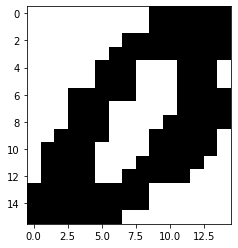

In [428]:
# Display a number to check
display_number = X_train[5]
display_number = np.resize(display_number, (16, 15))

plt.imshow(display_number, cmap='binary')
plt.show()

### 1.5 Normalice data

In [429]:
X_train = X_train/6
X_test = X_test/6

-----------
# 2. Model implementation: Decision tree with Kernel PCA dimension reduction

In [430]:
X_train.shape, y_train.shape

((1000, 240), (1000, 1))

#### With the original data

In [447]:
#Creating model and predicting output values on testing data. 
DT = DecisionTreeClassifier(criterion='entropy', random_state=np.random.RandomState(5))
DT = DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)

In [448]:
y_pred = np.resize(y_pred,(1000,))
y_test = np.resize(y_test,(1000,))

In [449]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.856

### Dimension reduction

In [434]:
pcakernel = KernelPCA(n_components=12, kernel='rbf')
X_train_reduced = pcakernel.fit_transform(X_train)
X_test_reduced = pcakernel.transform(X_test)

In [435]:
X_train_reduced.shape, X_test_reduced.shape

((1000, 12), (1000, 12))

In [436]:
#Creating model and predicting output values on testing data. 
DT = DecisionTreeClassifier(criterion='entropy', random_state=np.random.RandomState(5))
DT = DT.fit(X_train_reduced,y_train)
y_pred = DT.predict(X_test_reduced)

In [437]:
y_pred = np.resize(y_pred,(1000,))
y_test = np.resize(y_test,(1000,))

In [438]:
y_pred.shape, y_test.shape

((1000,), (1000,))

In [439]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.859

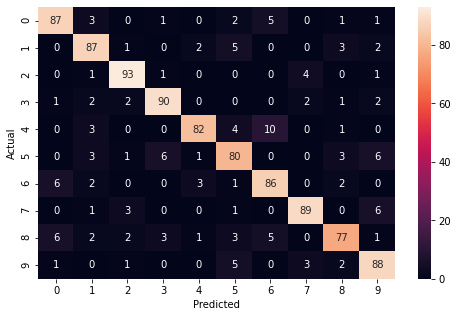

In [440]:
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

### 2.1 K-Fold function

In [441]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

def k_fold(folds):
    split_data = KFold(n_splits = folds, shuffle = True, random_state = np.random.RandomState(5))
    return split_data, folds

In [442]:
dt_k, dt_folds = k_fold(3)
dt_k_, dt_folds_ = k_fold(5)

input_data = dataset
label_data = dataset_labels

result = cross_val_score(DT , input_data, label_data, cv = dt_k)
print(f"Average accuracy from 3 folds: {result.mean()}\n")
result_ = cross_val_score(DT , input_data, label_data, cv = dt_k_)
print(f"Average accuracy from 5 folds: {result_.mean()}")


Average accuracy from 3 folds: 0.8635044339692016

Average accuracy from 5 folds: 0.8845000000000001


### 2.3 Grid search Function

In [443]:
def grid_search(model, hyper_params, score, folds):
    gs = GridSearchCV(estimator = model,
    param_grid = hyper_params,
    scoring = score,
    cv = folds,
    return_train_score = True)
    return gs    

In [444]:
#Search for optimal Decision Tree parameters
dt_hp = [{'criterion': ['entropy'],
       'splitter': ['best', 'random'],
       'max_depth': [3,4,5,6,7,None]}]

model_gs_ = grid_search(DT, dt_hp, 'accuracy', dt_k_)
model_gs_.fit(input_data, label_data)

GridSearchCV(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x7FF103AEBB40,
   shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=RandomState(MT19937) at 0x7FF103A80440),
             param_grid=[{'criterion': ['entropy'],
                          'max_depth': [3, 4, 5, 6, 7, None],
                          'splitter': ['best', 'random']}],
             return_train_score=True, scoring='accuracy')

In [445]:
print(f"Model best parameter with {dt_folds_} folds are: {model_gs_.best_params_}")

Model best parameter with 5 folds are: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'random'}


In [446]:
#Rest parameters are default in class object.
DT_best_ = DecisionTreeClassifier(criterion='entropy', max_depth= None, splitter= 'random')
result_ = cross_val_score(DT_best_ , input_data, label_data, cv = dt_k_)
print(f'Decision tree accuracy score with {dt_folds_} and optimal parameters: {result_.mean()}')

Decision tree accuracy score with 5 and optimal parameters: 0.8755000000000001
